<a href="https://colab.research.google.com/github/tejasj02/Mechanistic-Interpretability/blob/main/tiny_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Even Odd MLP
given an 8 bit input, output 1 is even number of 1s else 0

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

### Data Generation

First we need to generate data of 8 bit sequences

In [39]:
def generate_parity_data(n_samples=5000, seq_length=8):
    X, y = [], []
    for _ in range(n_samples):
        bits = [random.choice([0, 1]) for _ in range(seq_length)]
        parity = sum(bits) % 2   # 0 = even, 1 = odd
        X.append(bits)
        y.append(parity)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
X_train, y_train = generate_parity_data(2000, seq_length)
X_val, y_val = generate_parity_data(500, seq_length)

### Model
For the model lets keep it simple, just one hidden layer and focus more on interpretability later. The model should train very quick in just some seconds.

In [40]:
class ParityMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h  # keep h for interpretability

model = ParityMLP(input_dim=seq_length, hidden_dim=10)
print(model)

# Training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(200):
    model.train()
    logits, _ = model(X_train)
    loss = criterion(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Final training loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    logits, _ = model(X_val)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y_val).float().mean().item()
print(f"Validation accuracy: {acc:.3f}")

ParityMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)
Final training loss: 0.5672
Validation accuracy: 0.688


## Looking In
Let's look at some different interpretability methods, then hone on one neuron and look closer at our previous methods.

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

Weight-Space Clustering

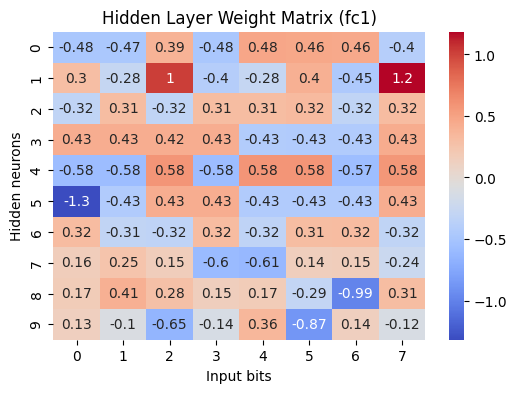

Cluster labels for neurons: [1 2 2 2 0 0 1 1 2 1]


In [42]:
fc1_weights = model.fc1.weight.data.numpy()  # shape [hidden_dim, input_dim]
kmeans = KMeans(n_clusters=3, random_state=0).fit(fc1_weights)

plt.figure(figsize=(6,4))
sns.heatmap(fc1_weights, annot=True, cmap="coolwarm", cbar=True)
plt.title("Hidden Layer Weight Matrix (fc1)")
plt.xlabel("Input bits")
plt.ylabel("Hidden neurons")
plt.show()

print("Cluster labels for neurons:", kmeans.labels_)

### Activation Trajectory Mapping

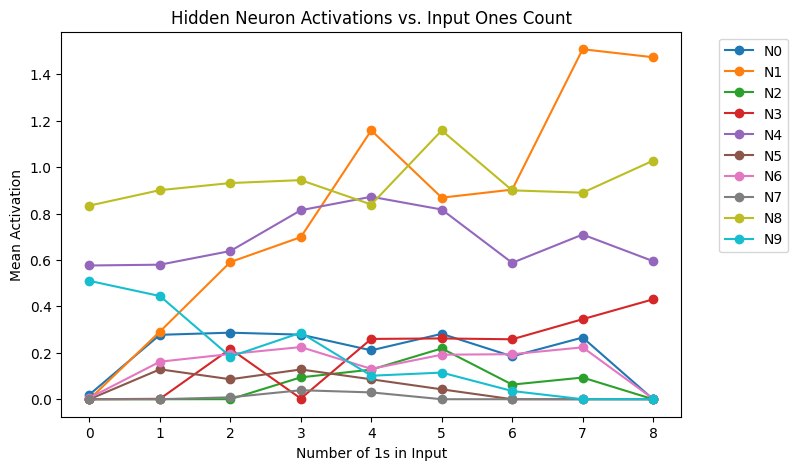

In [43]:
def activation_map(model, seq_length=8):
    all_inputs = []
    all_acts = []
    for n_ones in range(seq_length+1):
        # All binary vectors with exactly n_ones ones
        base = torch.zeros((1, seq_length))
        sample = base.repeat(10, 1)
        for i in range(10):
            ones_idx = np.random.choice(seq_length, n_ones, replace=False)
            sample[i, ones_idx] = 1
        with torch.no_grad():
            _, h = model(sample)
        all_inputs.append(n_ones)
        all_acts.append(h.mean(0).numpy())  # average across samples
    return np.array(all_inputs), np.array(all_acts)

ones_count, mean_acts = activation_map(model)

plt.figure(figsize=(8,5))
for neuron_idx in range(mean_acts.shape[1]):
    plt.plot(ones_count, mean_acts[:, neuron_idx], marker='o', label=f"N{neuron_idx}")
plt.xlabel("Number of 1s in Input")
plt.ylabel("Mean Activation")
plt.title("Hidden Neuron Activations vs. Input Ones Count")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

### Gradient Based Sensitivity

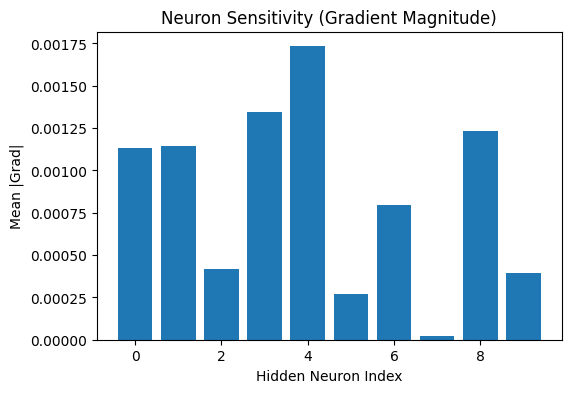

Most sensitive neuron: 4


In [44]:
X_val.requires_grad_(True)

# We need to retain gradients on the hidden layer
h = None
def hook_fn(module, input, output):
    global h
    h = output
    h.retain_grad()

hook = model.fc1.register_forward_hook(hook_fn)

outputs, _ = model(X_val)
loss = torch.nn.functional.cross_entropy(outputs, y_val)
loss.backward()

grad_importance = h.grad.abs().mean(dim=0).detach().numpy()

plt.figure(figsize=(6,4))
plt.bar(range(len(grad_importance)), grad_importance)
plt.title("Neuron Sensitivity (Gradient Magnitude)")
plt.xlabel("Hidden Neuron Index")
plt.ylabel("Mean |Grad|")
plt.show()

top_neuron = int(np.argmax(grad_importance))
print(f"Most sensitive neuron: {top_neuron}")

hook.remove()

For neuron 4, I think it must be detecting evens or odds given the problem. I would think it utilizes some count weights and activates based on those to determine even and odd.

### Focus on Neuron 4

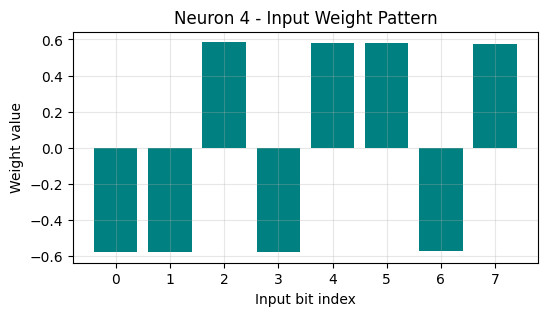

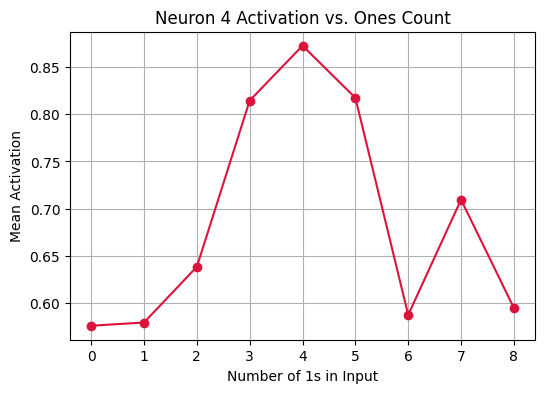

/tmp/ipython-input-1664521900.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


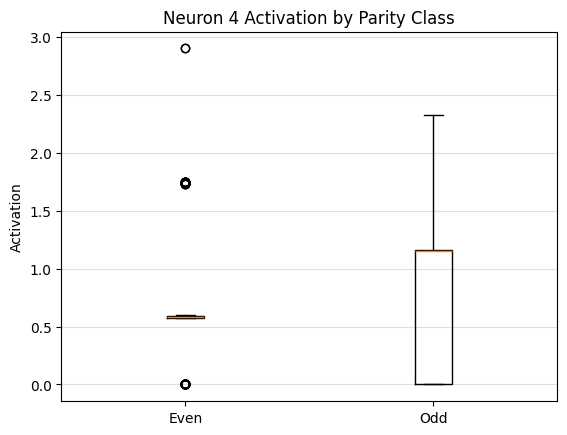

In [46]:
neuron_idx = 4

# Weight pattern for neuron 4
plt.figure(figsize=(6,3))
plt.bar(range(model.fc1.weight.shape[1]),
        model.fc1.weight[neuron_idx].detach().numpy(),
        color="teal")
plt.xlabel("Input bit index")
plt.ylabel("Weight value")
plt.title(f"Neuron {neuron_idx} - Input Weight Pattern")
plt.grid(True, alpha=0.3)
plt.show()

# Activation trajectory vs. number of 1s
plt.figure(figsize=(6,4))
plt.plot(ones_count, mean_acts[:, neuron_idx],
         marker='o', color='crimson')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Mean Activation")
plt.title(f"Neuron {neuron_idx} Activation vs. Ones Count")
plt.grid(True)
plt.show()

# Activation contrast: even vs. odd parity
even_mask = (y_val == 0)
odd_mask = (y_val == 1)
with torch.no_grad():
    _, h = model(X_val)
plt.boxplot(
    [h[even_mask, neuron_idx].numpy(),
     h[odd_mask, neuron_idx].numpy()],
    labels=["Even", "Odd"],
)
plt.title(f"Neuron {neuron_idx} Activation by Parity Class")
plt.ylabel("Activation")
plt.grid(True, axis='y', alpha=0.4)
plt.show()

Based on the graphs, we can see a little about what goes on in neuron 4. From the weights chart, we see almost alternating weights for each bit. This was likely a shortcut done by the model on limited training and lack of nonlinearity. This is its shortcut to defining parity. Neuron 4 also has activation spikes aroud when there are 3-5 ones. These regions are where parity transitions often happen in the 8 bit space (more common to find 8 bit sequences with this amount of 1s). Therefore it isn't really tracking the count of 1s but looking at the parity boundaries to determine these. In our last graph, we can see the activation for even is largely the same across values but for odd it is much more variable. The activation lights up for odd inputs much more often, indicating it acts as an odd number notifier.

Overall, it can be said neuron 4 encodes a parity-sensitive feature that responds when total bit count reaches the common transition phases and alerts mainly for odd cases.

## Reflection

I learned about how the activation functions play a part as well as weight distributions across neurons. It was interesting to see how different parts of the model are focused for different components of the task. A struggle I had was with how the model learns to count 1s intuitively. Thinking in 8-bit and what counts of 1s are most common was weird, and then understanding that given the limited architecture and training this was how a model must attack this task was difficult. I want to better understand how the neurons work together. This would be best in a more complex task and see given many cases how their relationships change.